# Income-Prediction-Classification

# Imports

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [52]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(15,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)
def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/adult.csv")
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Check For Nulls / Dupes

In [6]:
check_for_nulls_dupes(df)

The amount of Null Values: age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64
The amount of Duplicated Values 52


In [7]:
df.drop_duplicates(inplace=True)

In [20]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Check For Class Imbalance

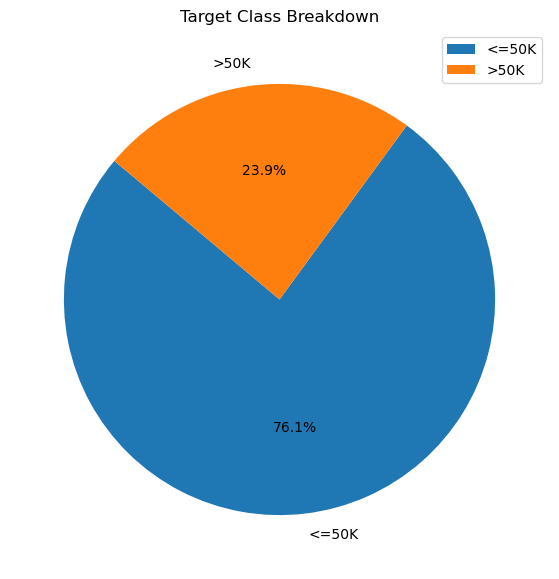

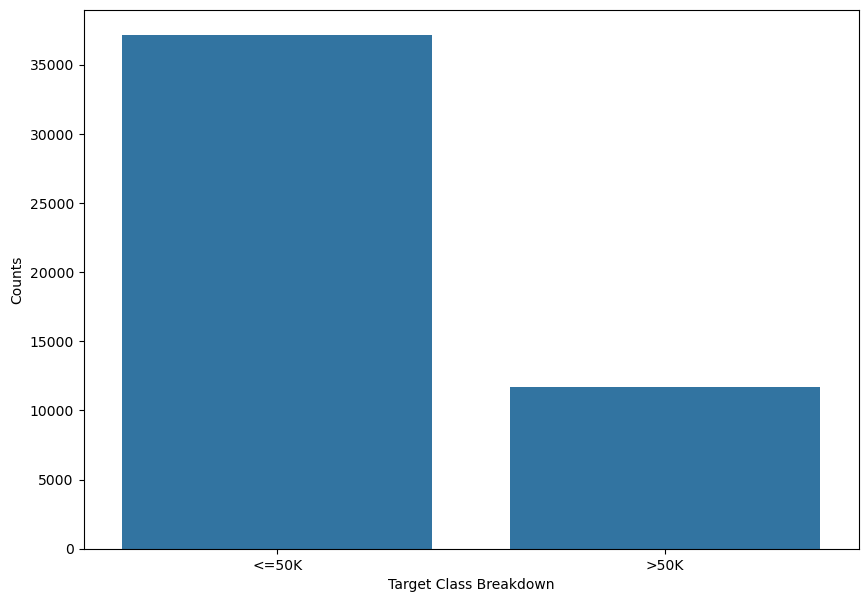

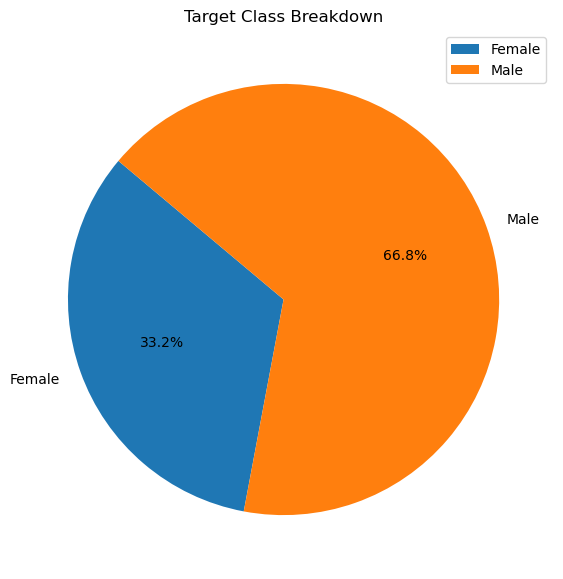

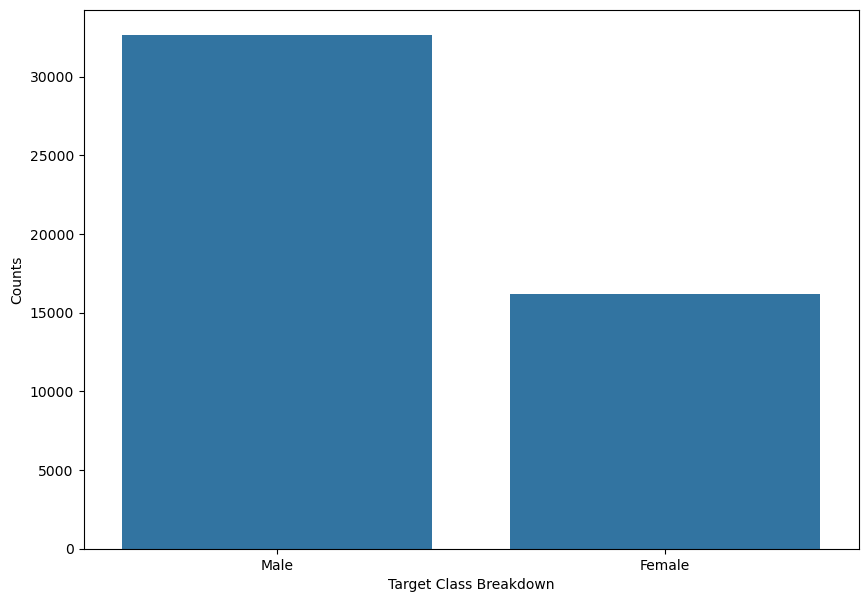

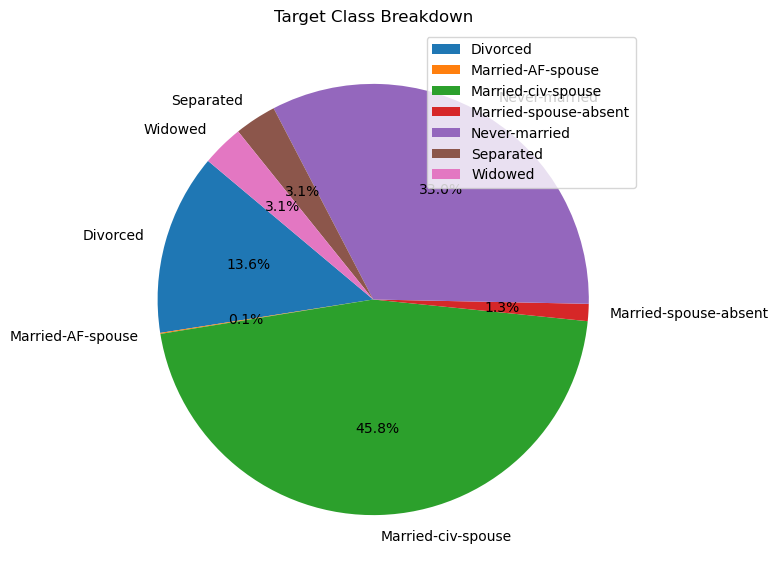

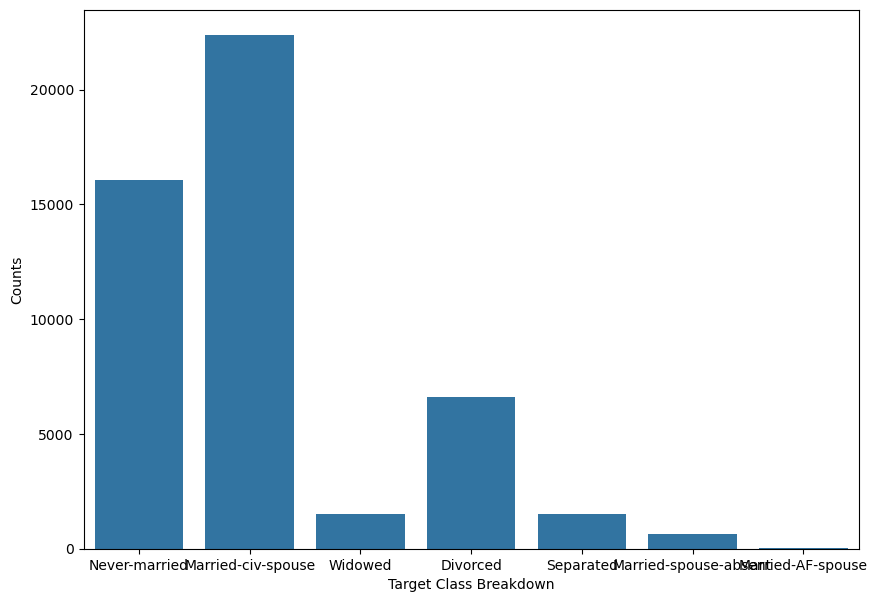

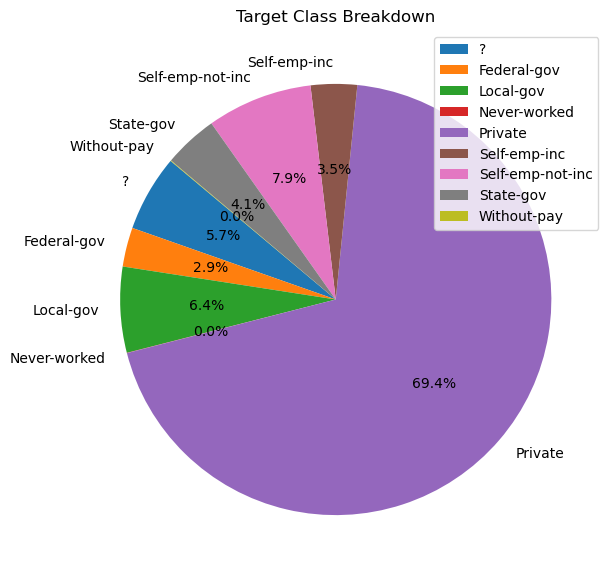

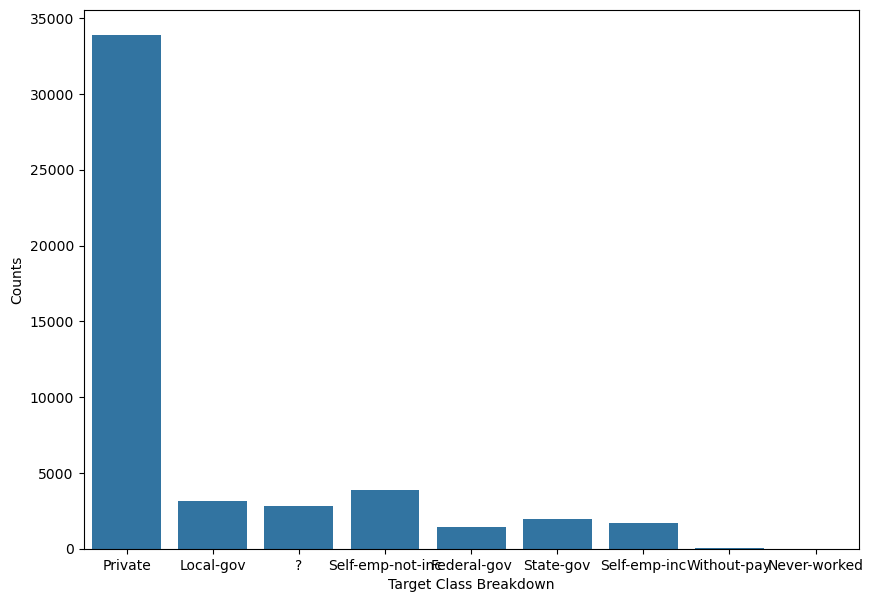

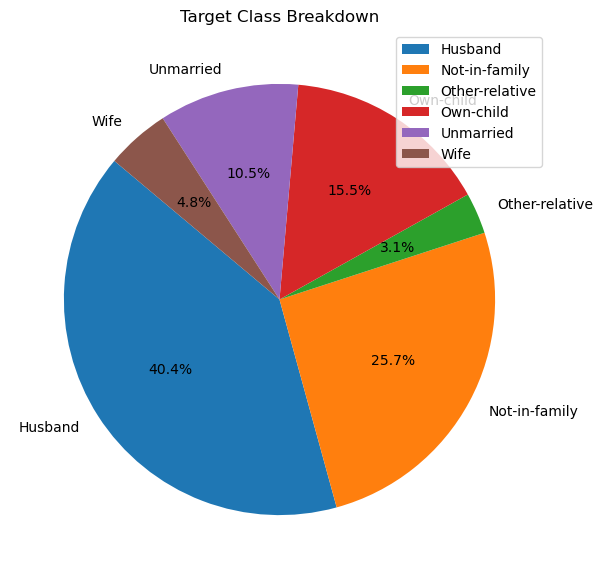

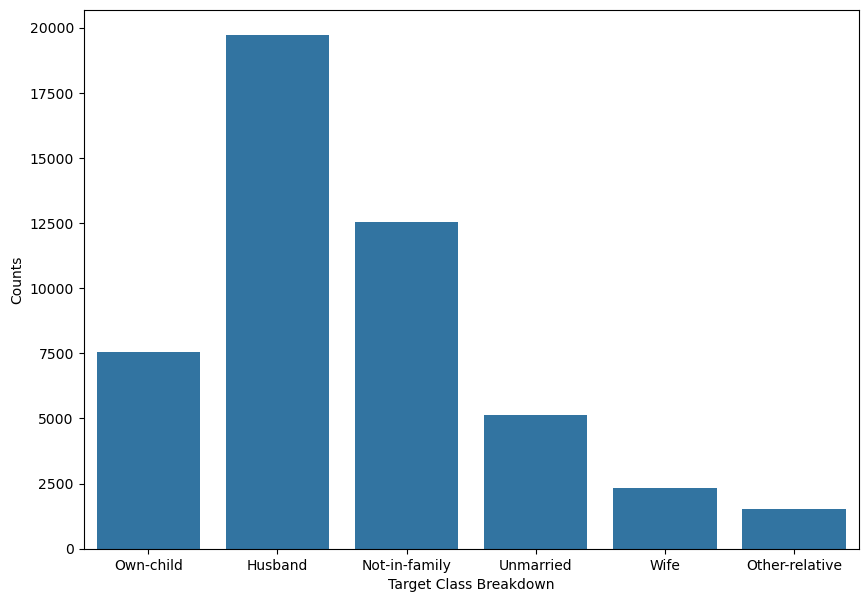

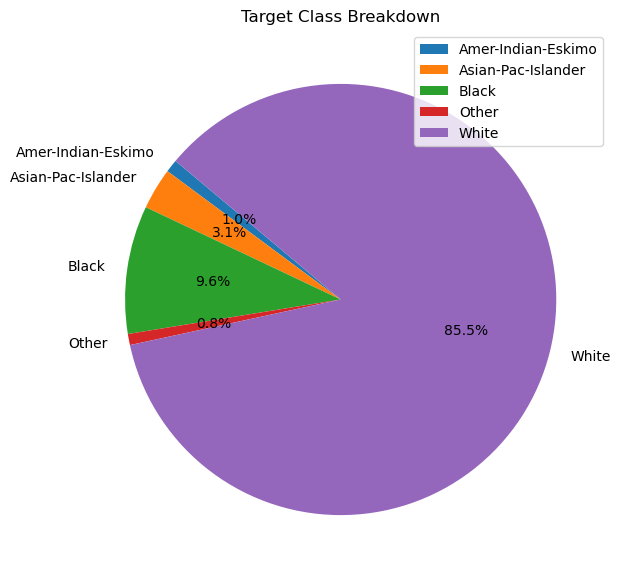

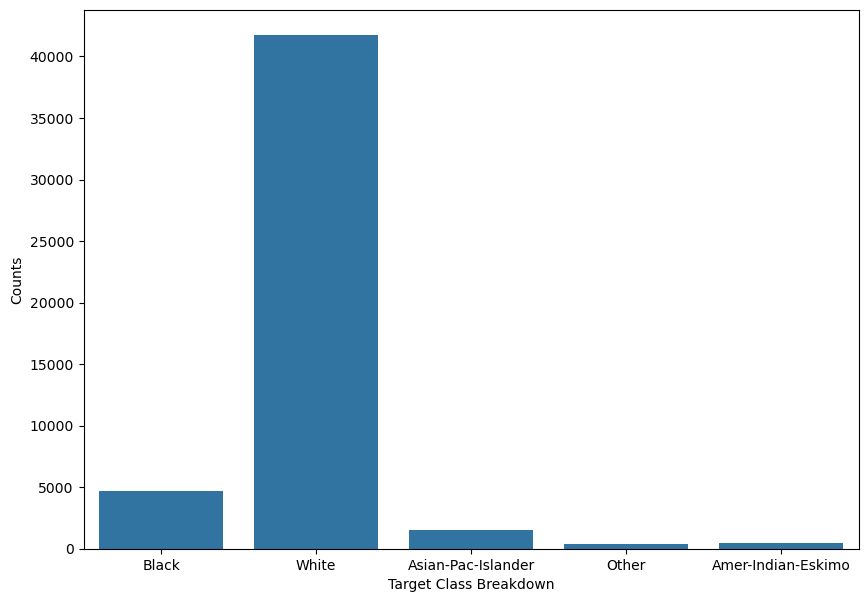

In [27]:
check_class_imbalance(df["income"])
check_class_imbalance(df["gender"])
check_class_imbalance(df["marital-status"])
check_class_imbalance(df["workclass"])
check_class_imbalance(df["relationship"])
check_class_imbalance(df["race"])

#### Data is heavily skewed to individuals with a white ethnic background

In [31]:
df.drop(["native-country", "workclass", "occupation", "race"], axis=1, inplace=True)

In [32]:
df.dtypes

age                 int64
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
relationship       object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
income             object
dtype: object

In [34]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

# Histogram

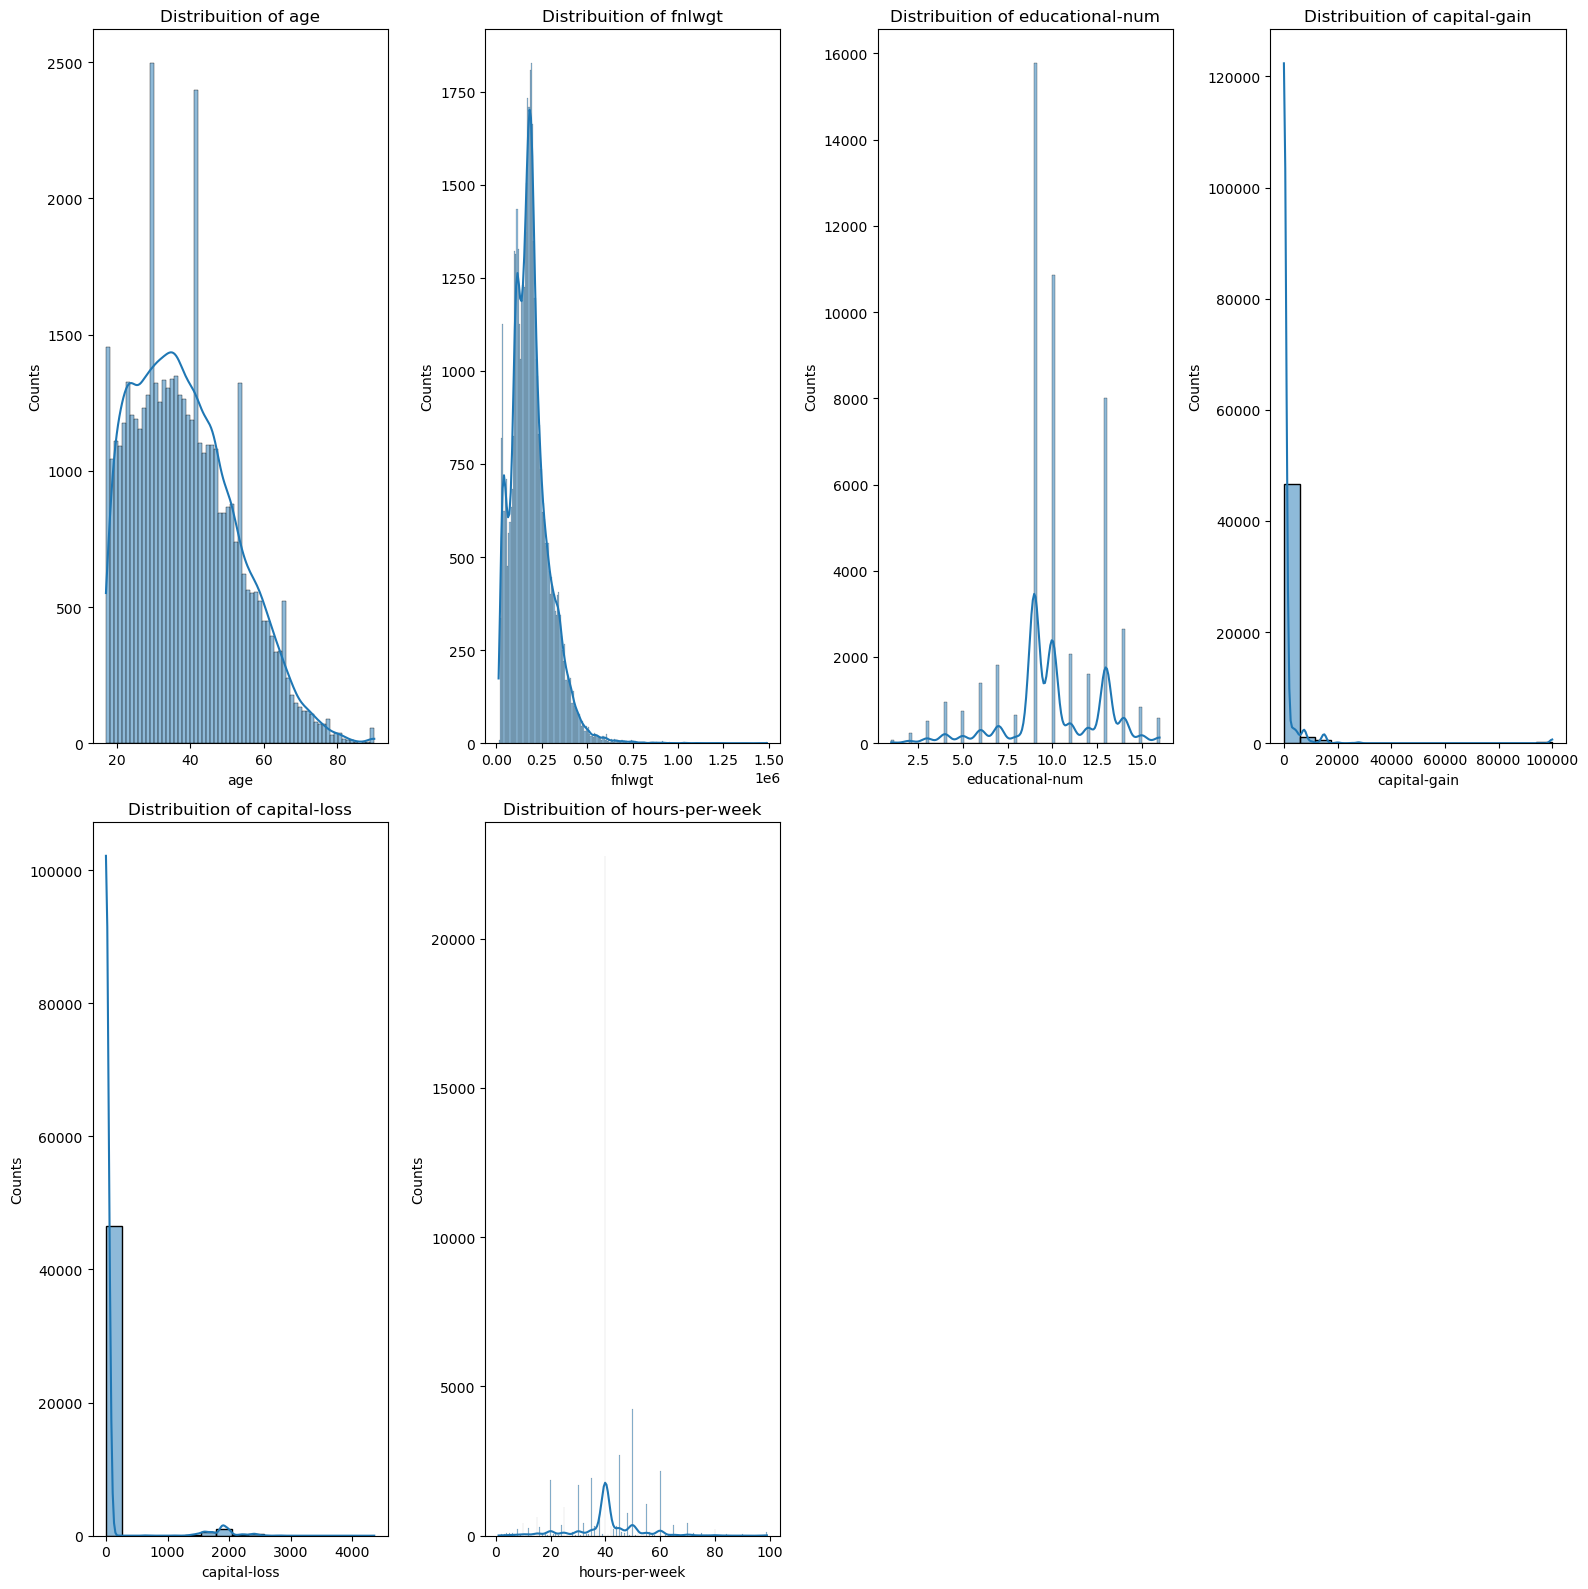

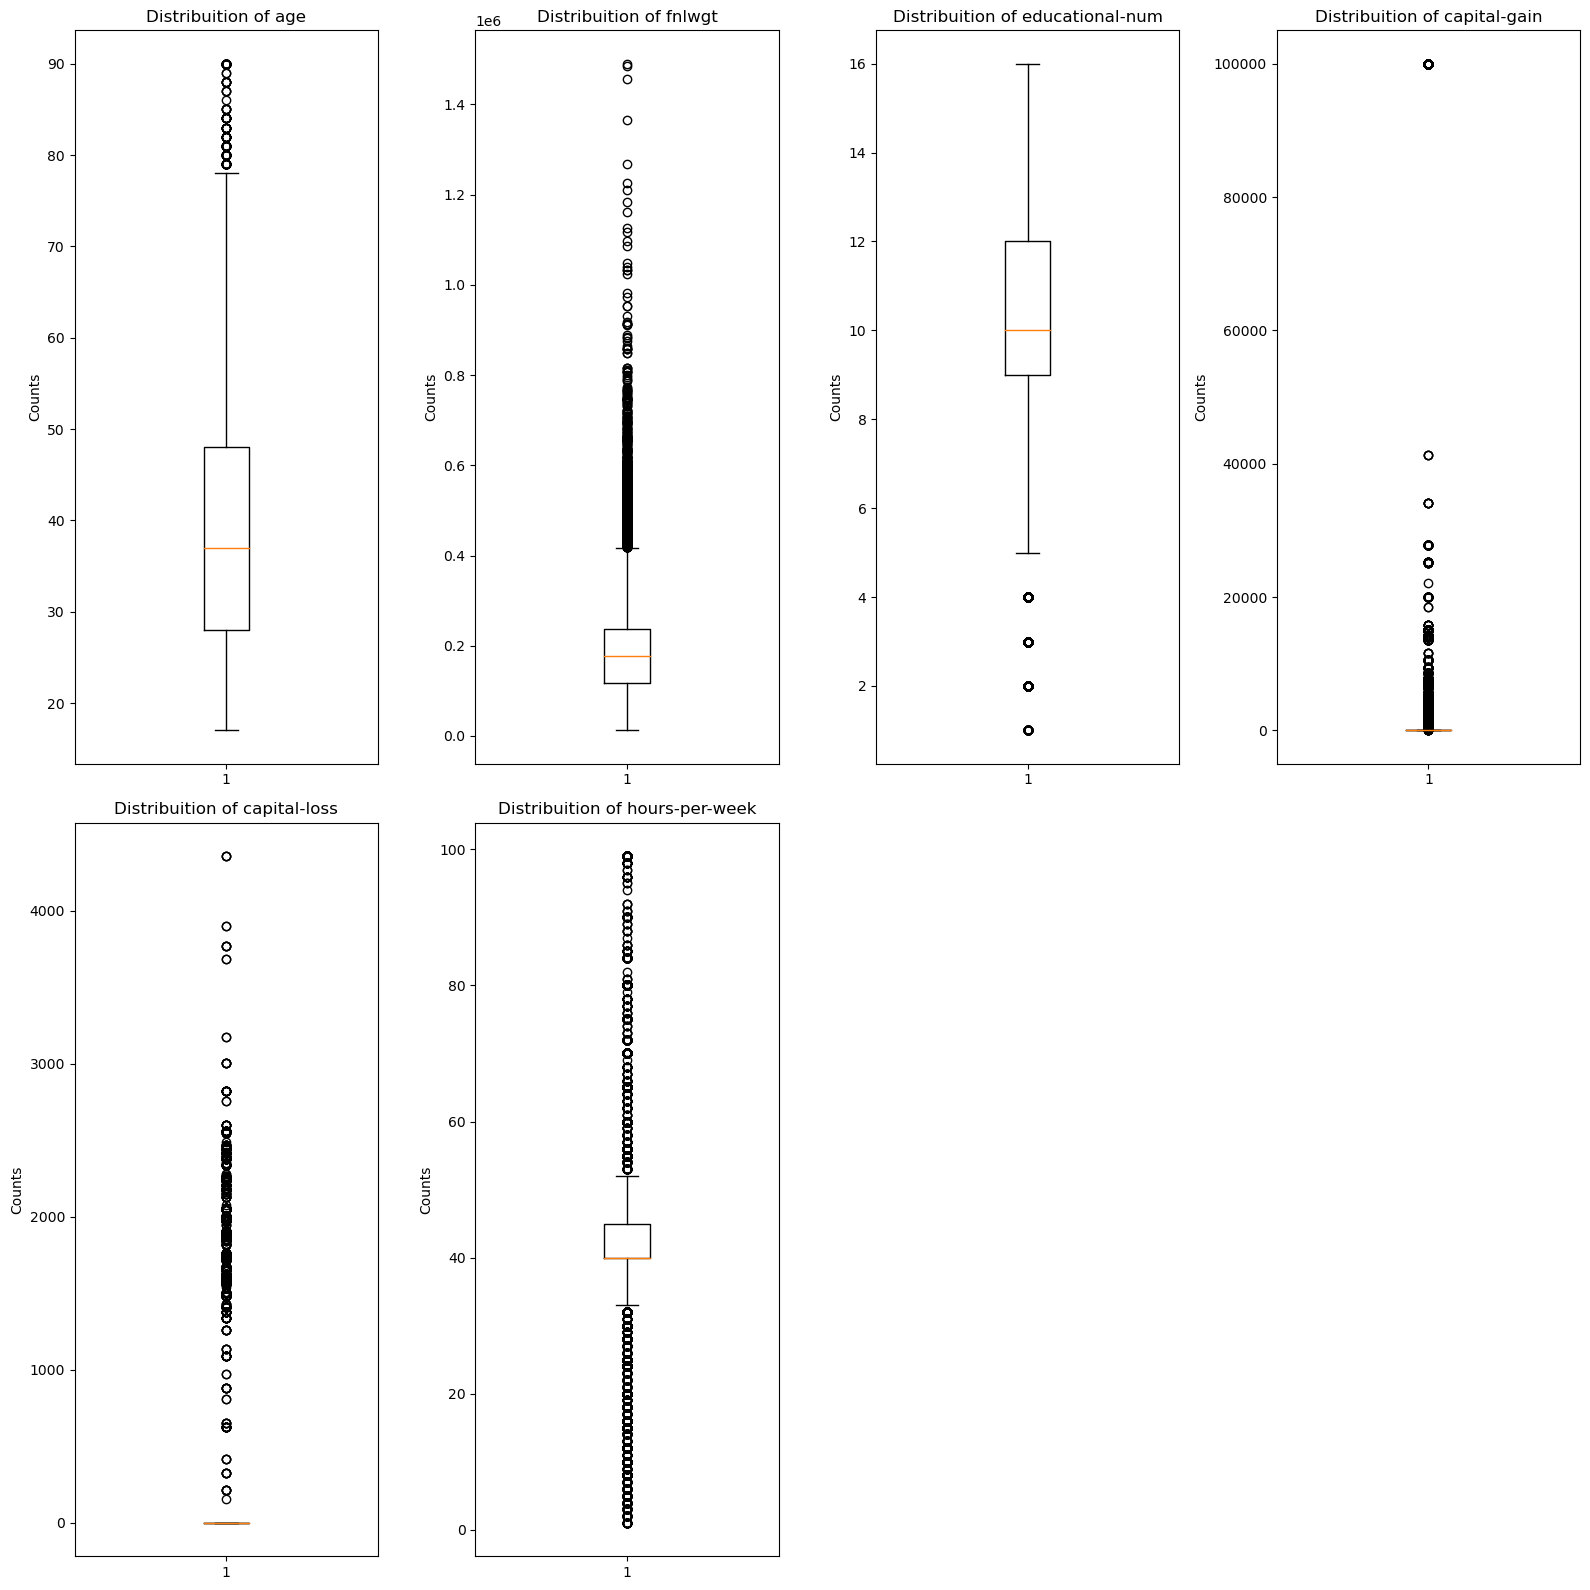

In [35]:
plot_distribution(numerical_types, "hist")
plot_distribution(numerical_types, "box")

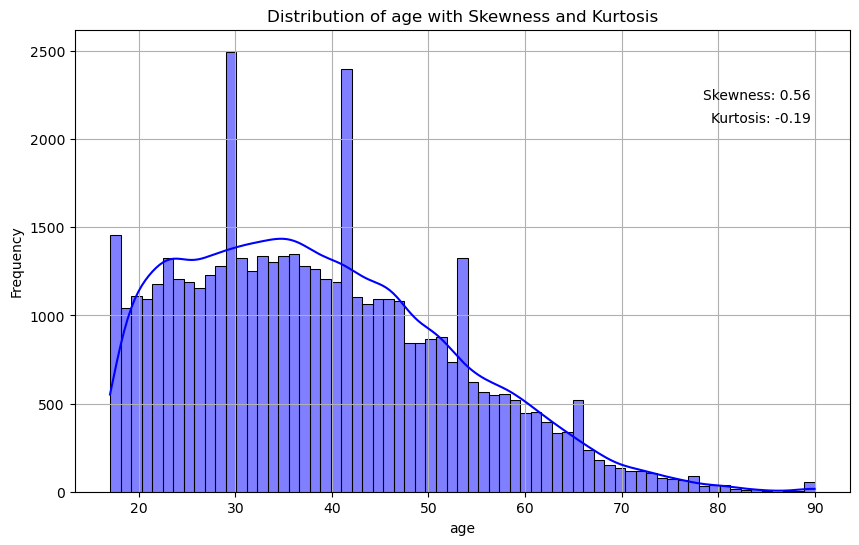

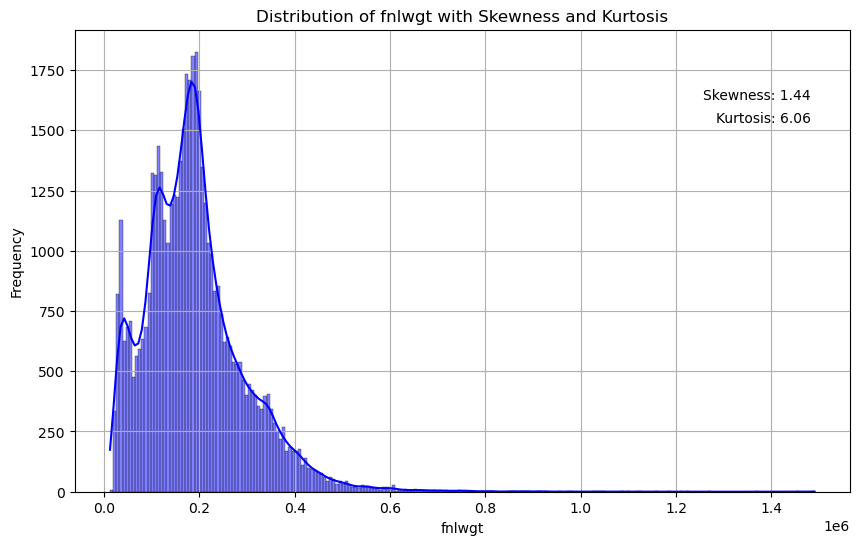

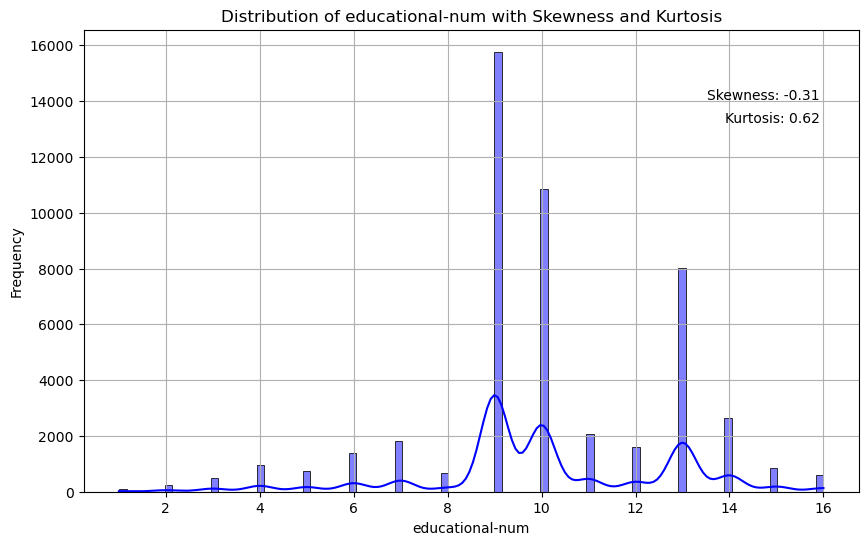

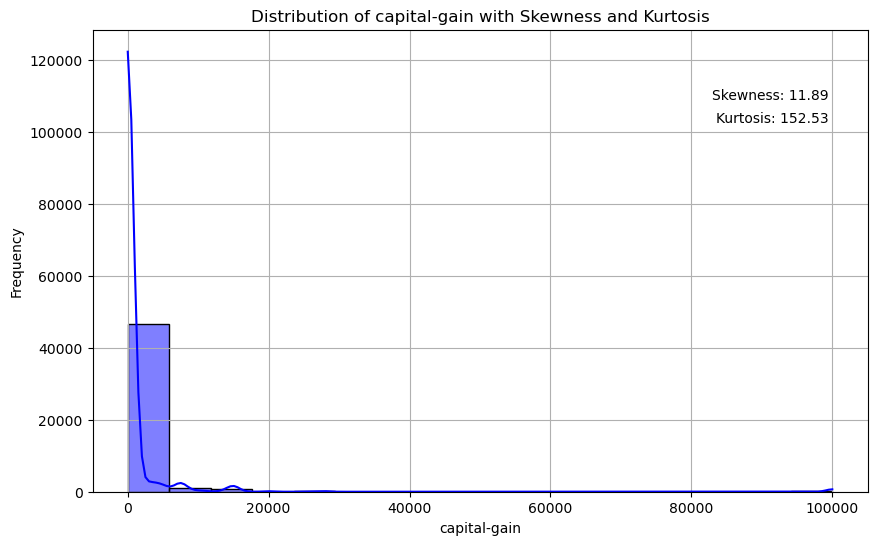

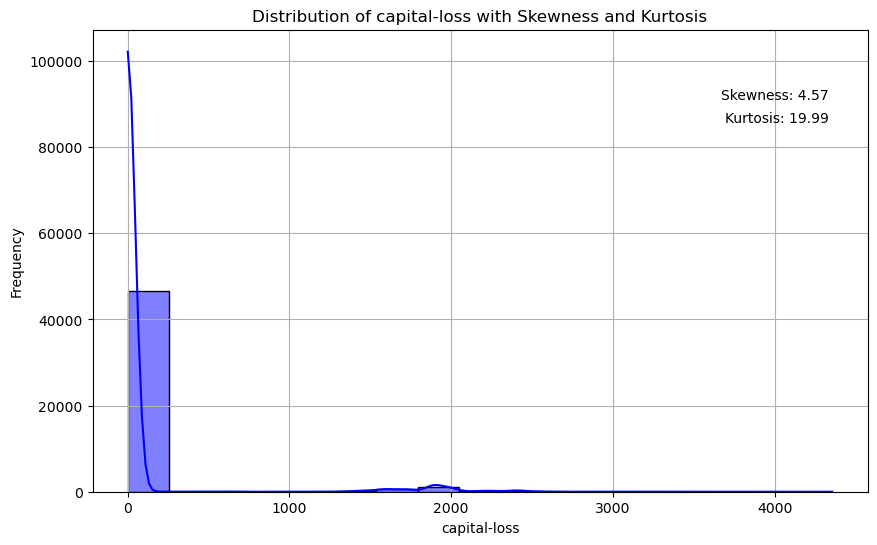

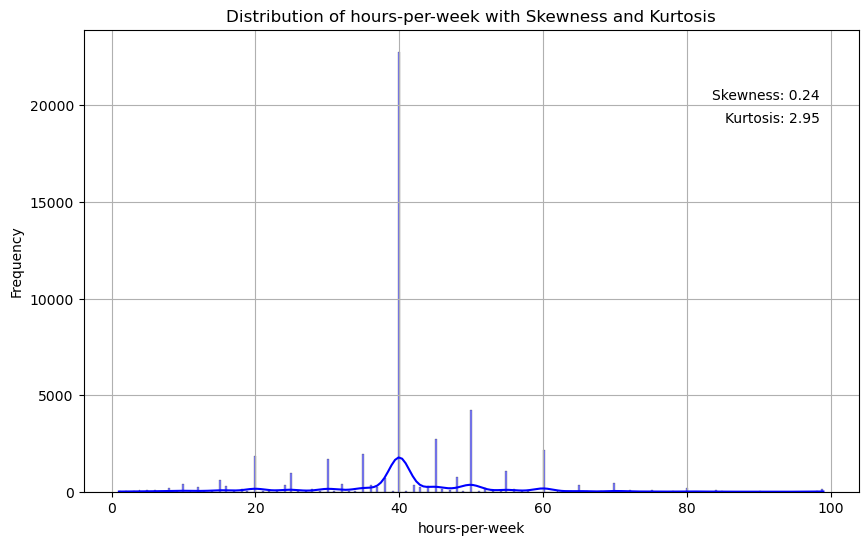

In [37]:
dist_plot(numerical_types)

# Aggregations

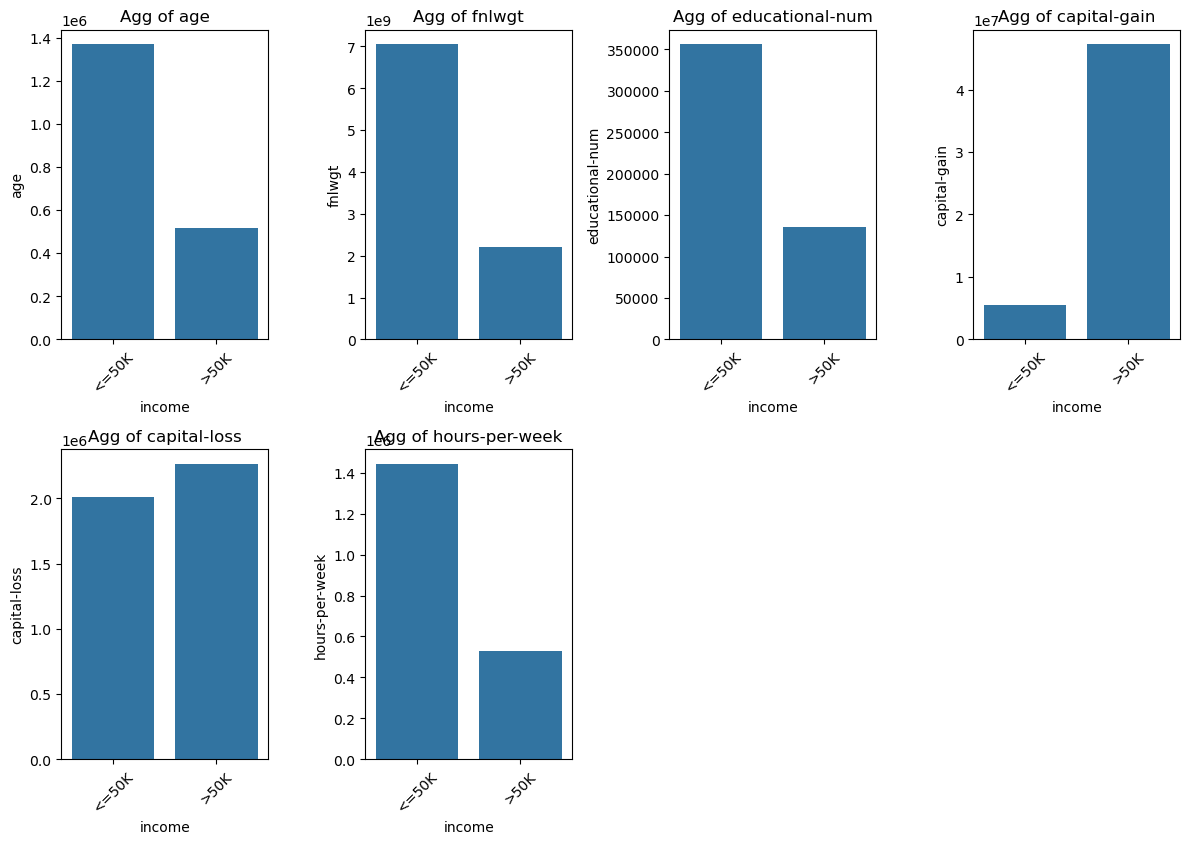

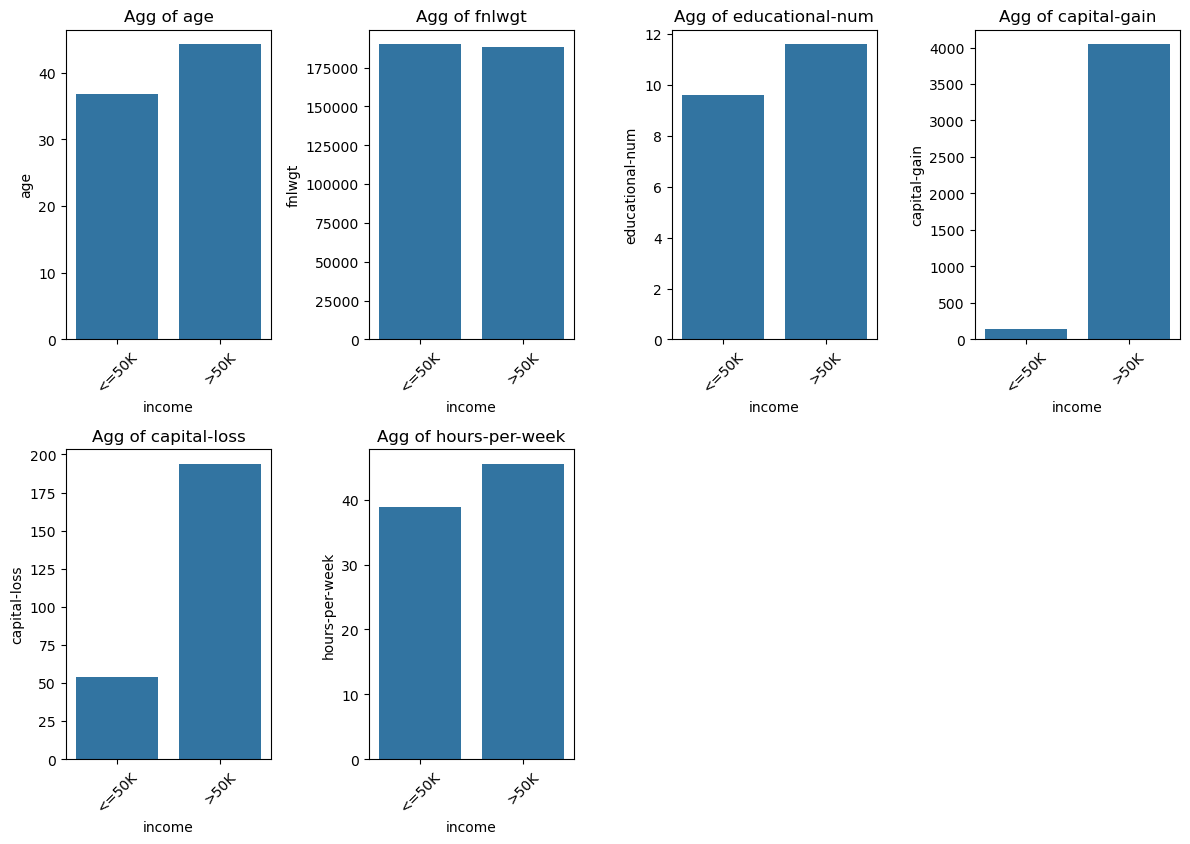

In [38]:
aggregate_dataset(df, numerical_types.columns, "income", "sum")
aggregate_dataset(df, numerical_types.columns, "income", "mean")

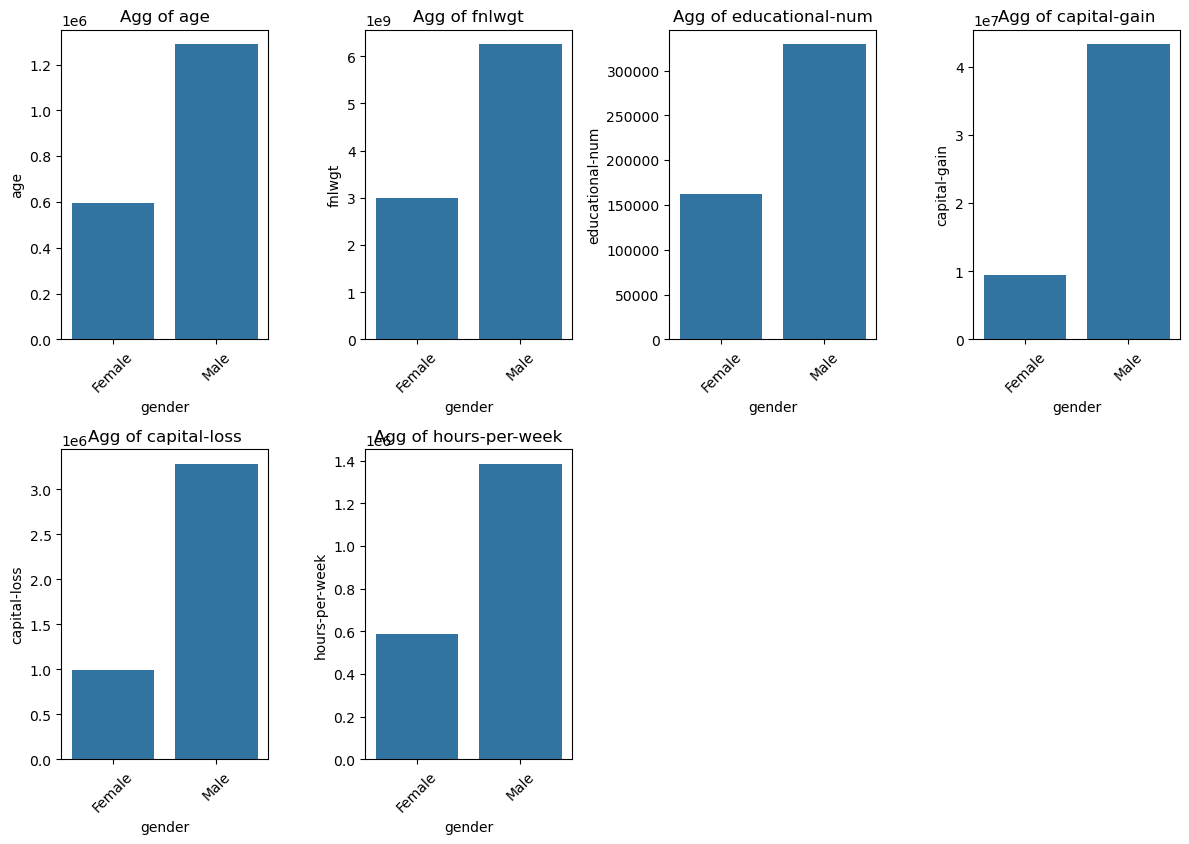

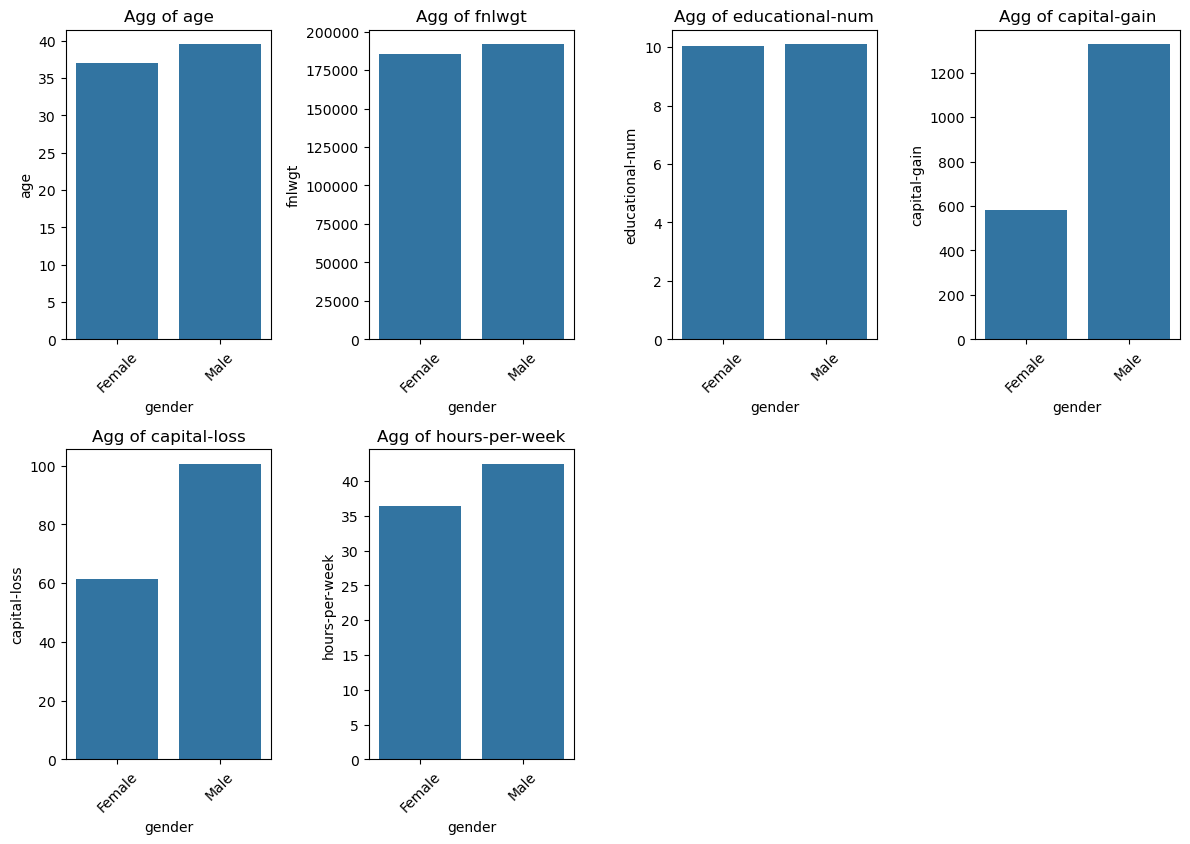

In [40]:
aggregate_dataset(df, numerical_types.columns, "gender", "sum")
aggregate_dataset(df, numerical_types.columns, "gender", "mean")

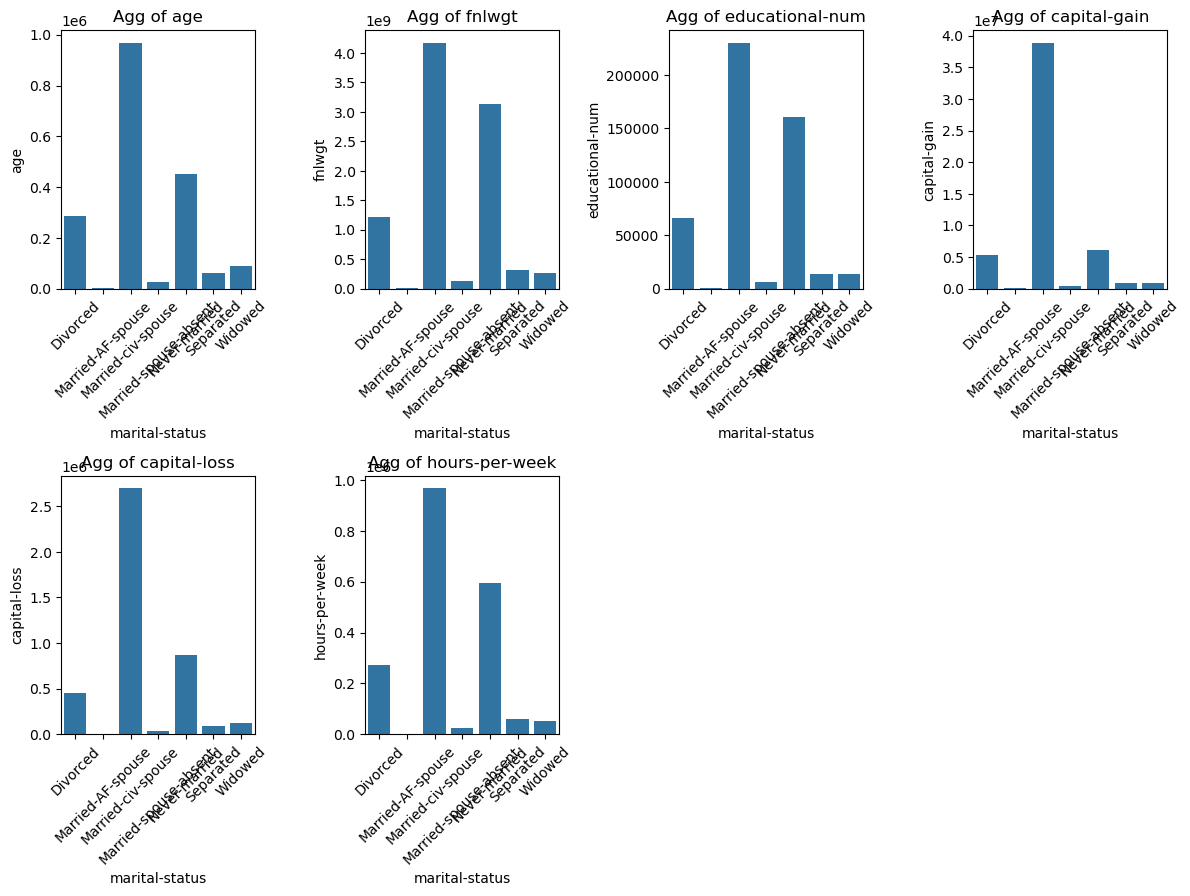

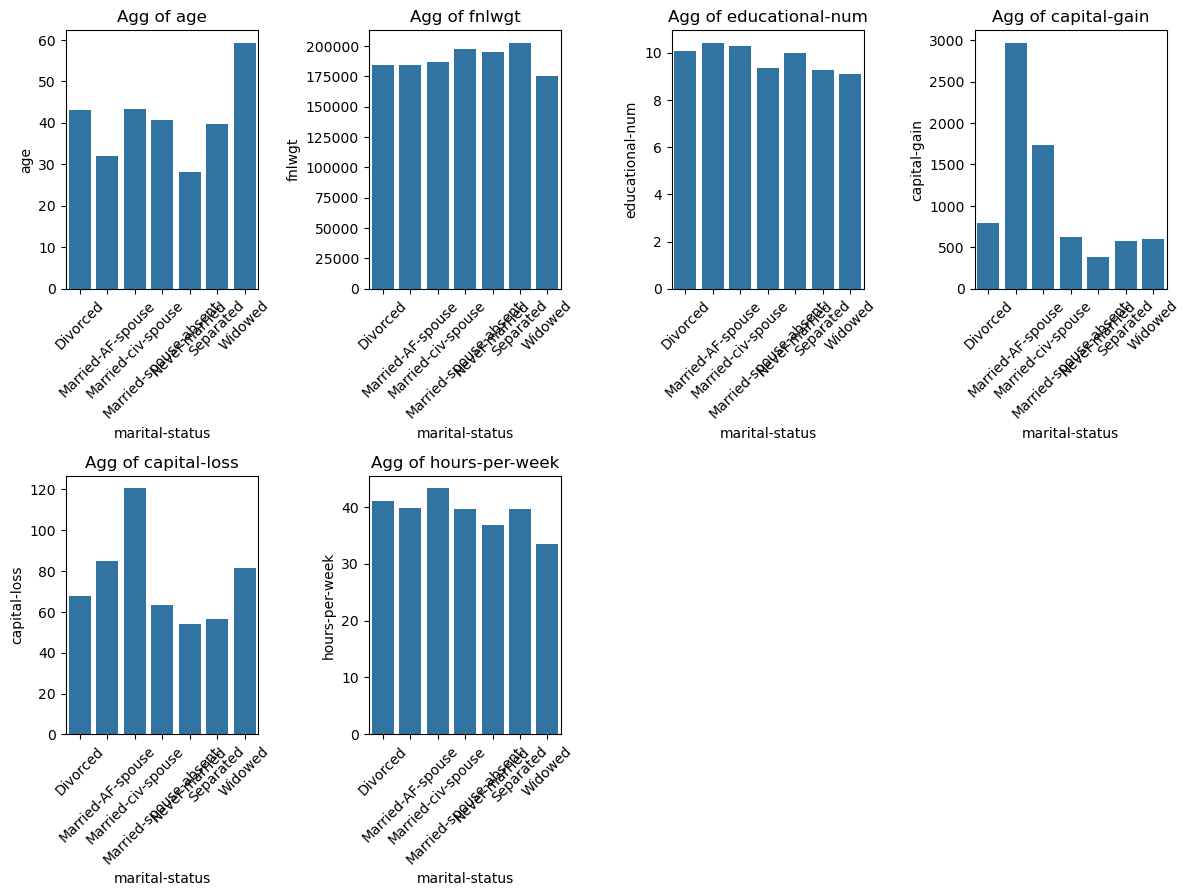

In [41]:
aggregate_dataset(df, numerical_types.columns, "marital-status", "sum")
aggregate_dataset(df, numerical_types.columns, "marital-status", "mean")

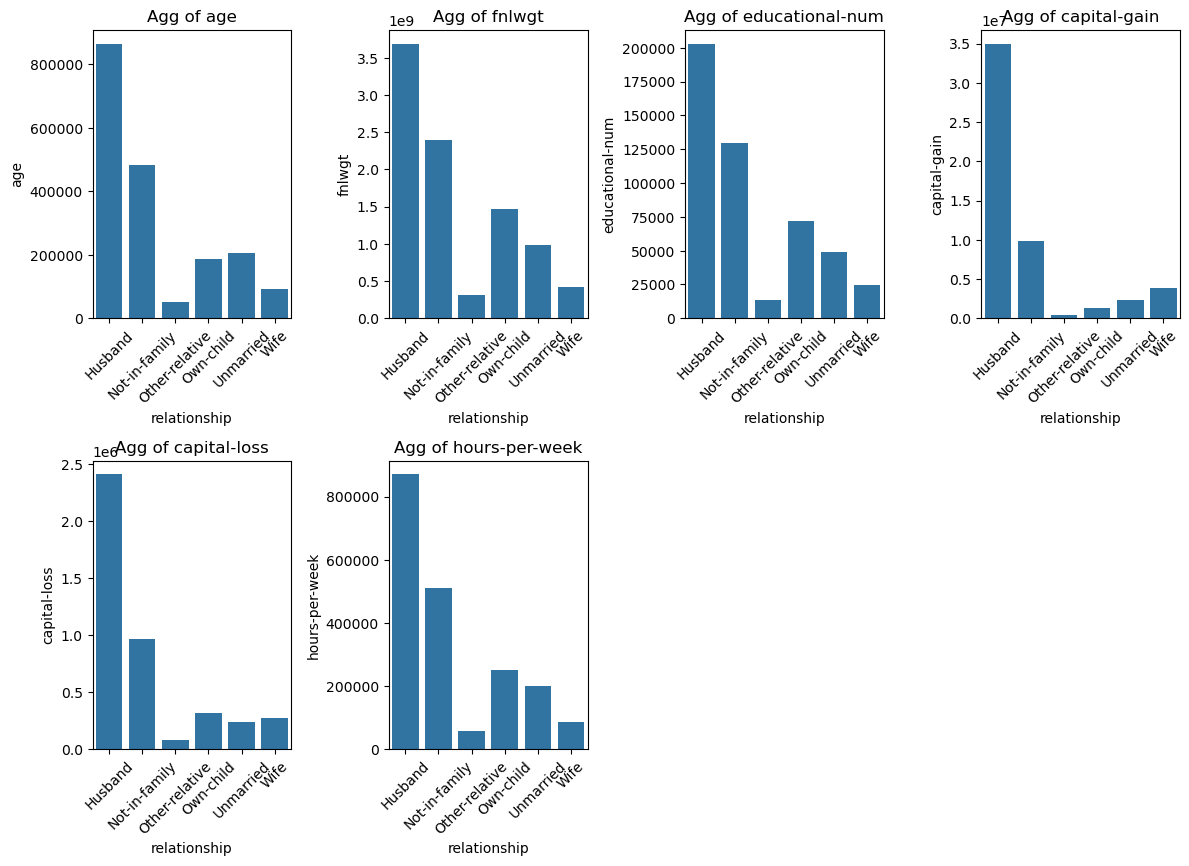

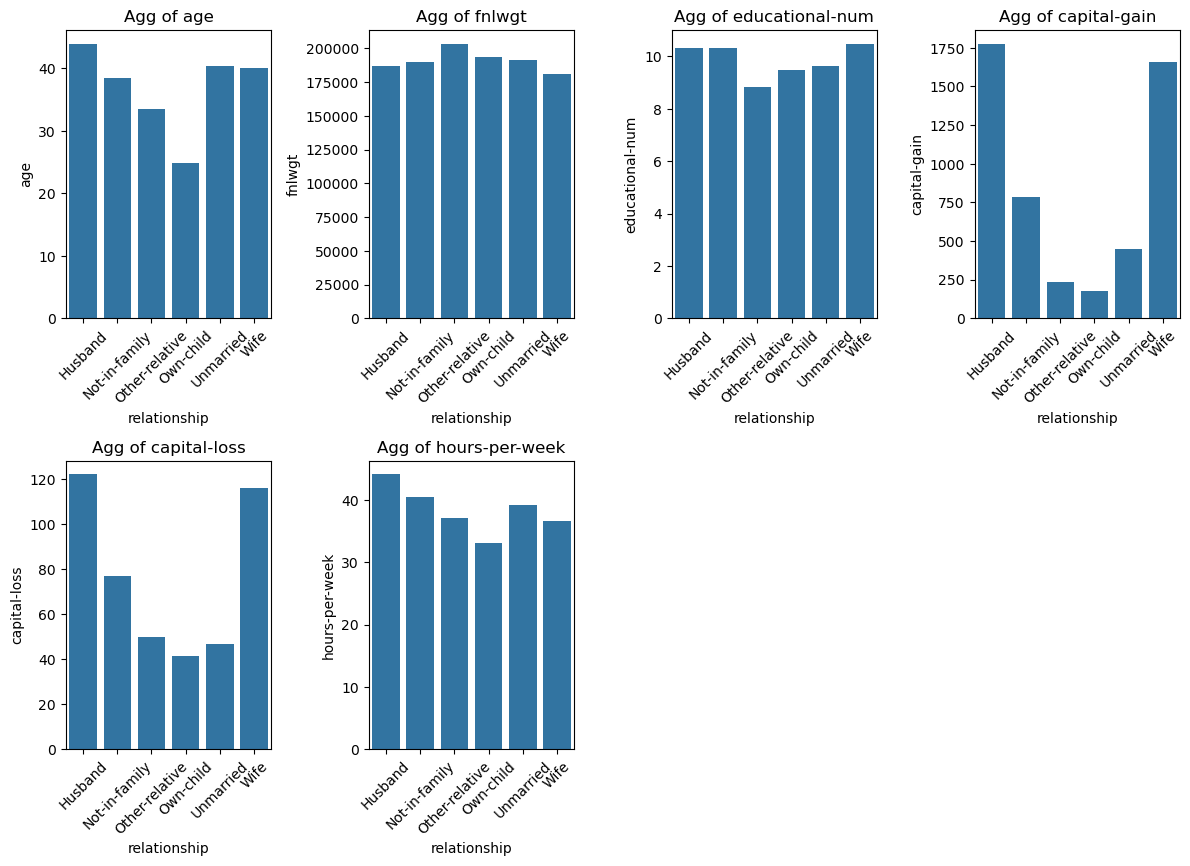

In [43]:
aggregate_dataset(df, numerical_types.columns, "relationship", "sum")
aggregate_dataset(df, numerical_types.columns, "relationship", "mean")

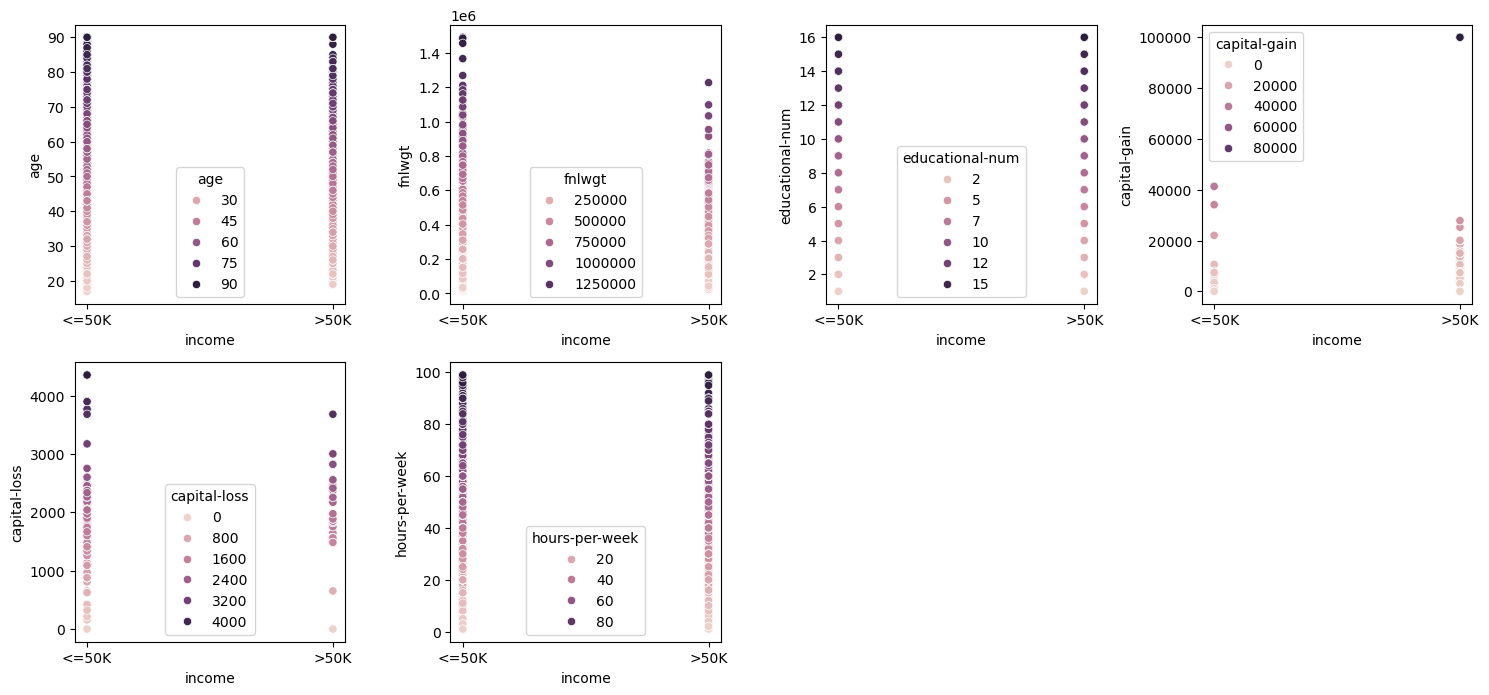

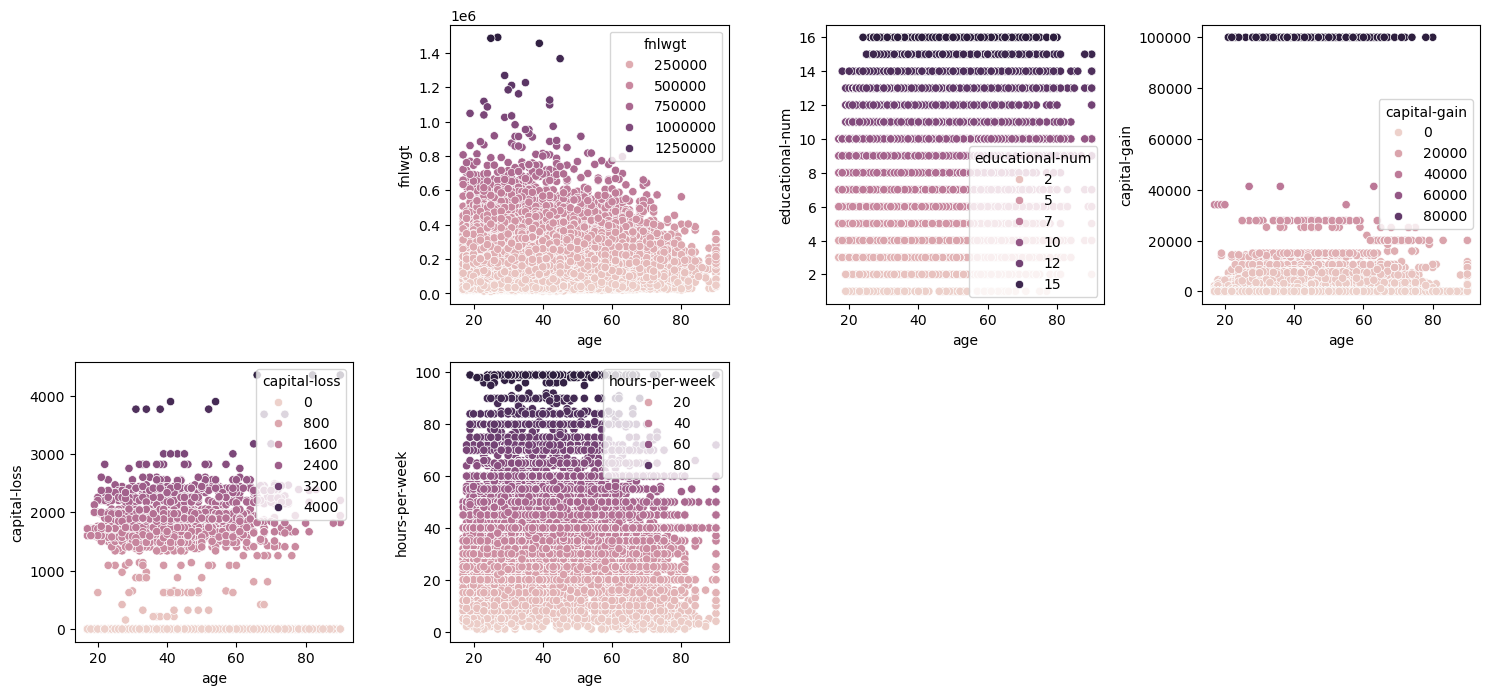

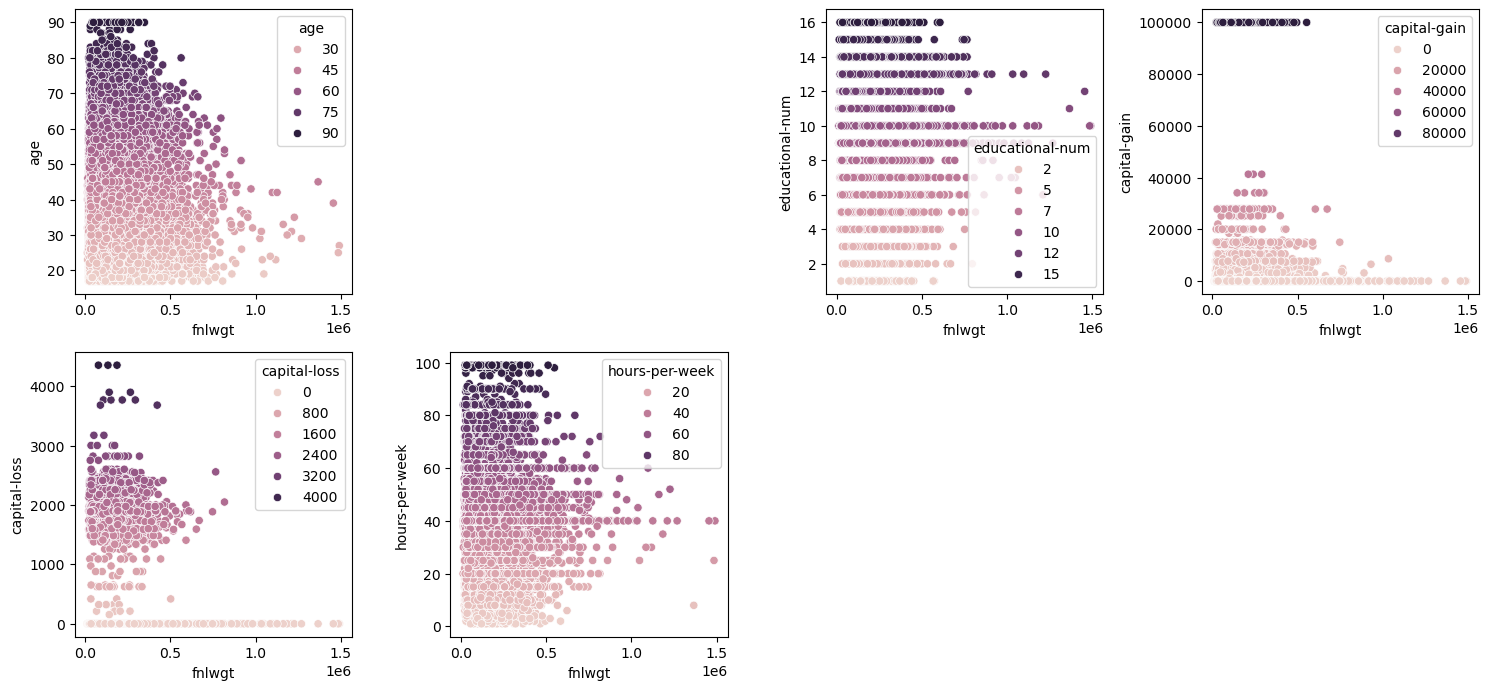

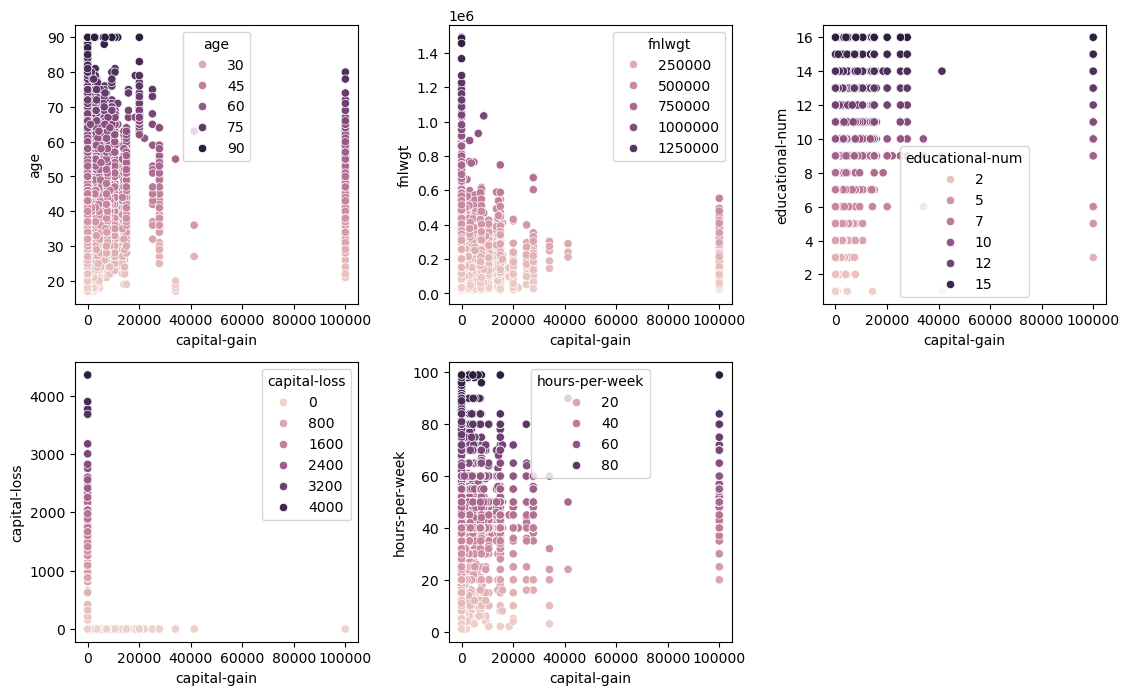

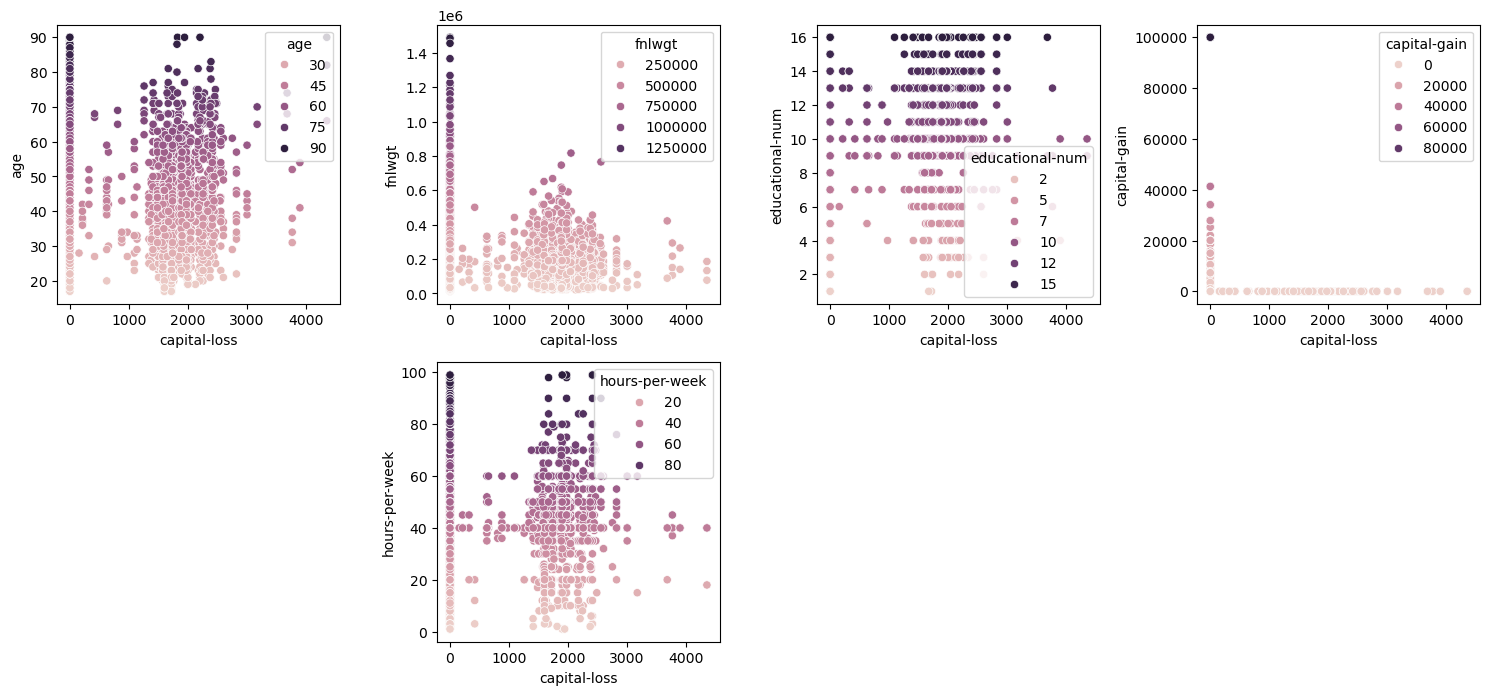

In [49]:
scatter_plot(df, numerical_types.columns, "income")
scatter_plot(df, numerical_types.columns, "age")
scatter_plot(df, numerical_types.columns, "fnlwgt")
scatter_plot(df, numerical_types.columns, "capital-gain")
scatter_plot(df, numerical_types.columns, "capital-loss")

# Heatmap

<AxesSubplot:>

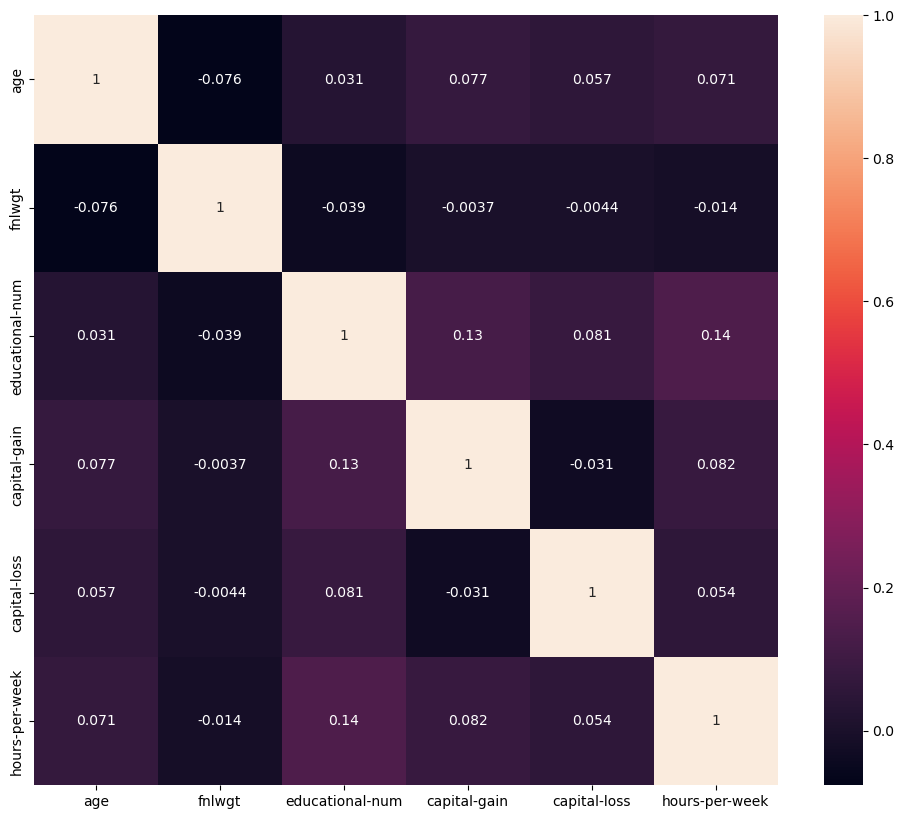

In [53]:
relations = numerical_types.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data=relations, annot=True)

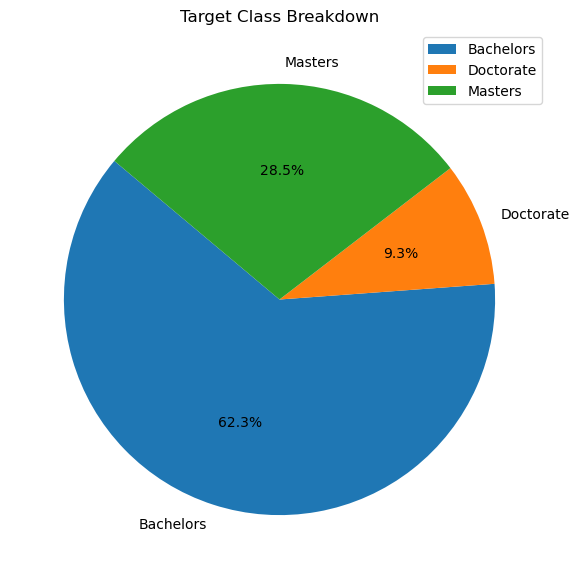

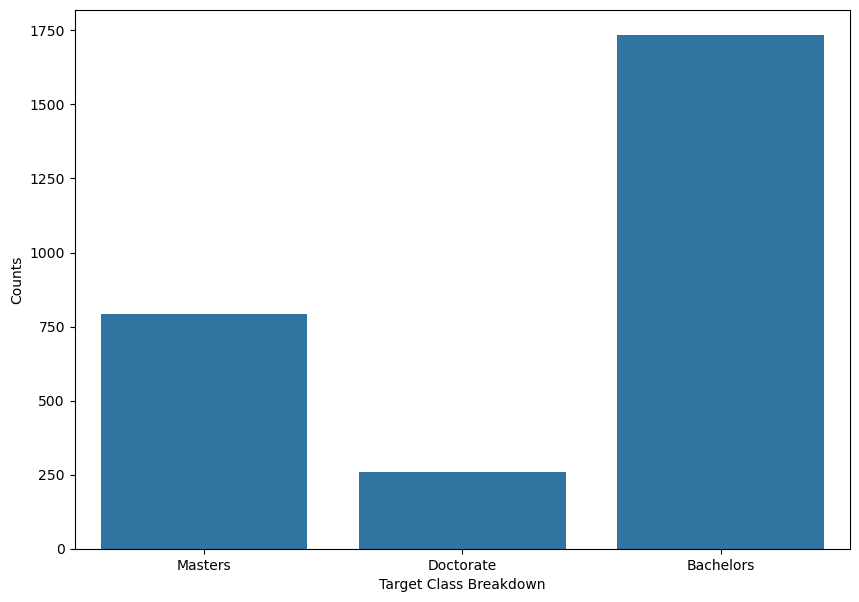

In [64]:
long_hours_high_earners = df[(df["income"] == ">50K") & (df["hours-per-week"] > 40) & (df["education"].isin(["Masters", "Doctorate", "Bachelors"]))]
check_class_imbalance(long_hours_high_earners["education"])

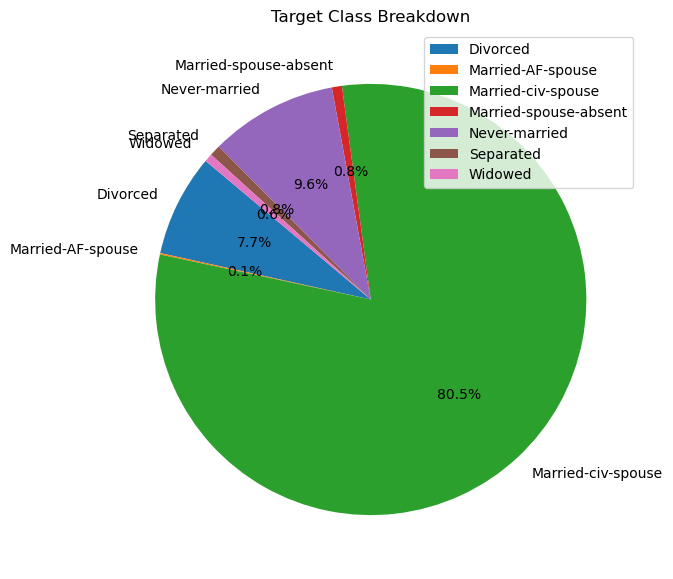

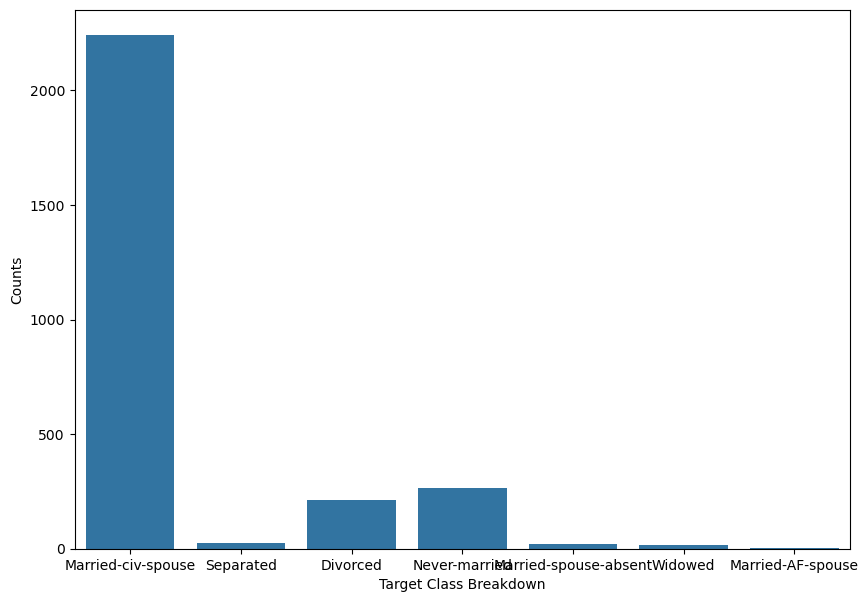

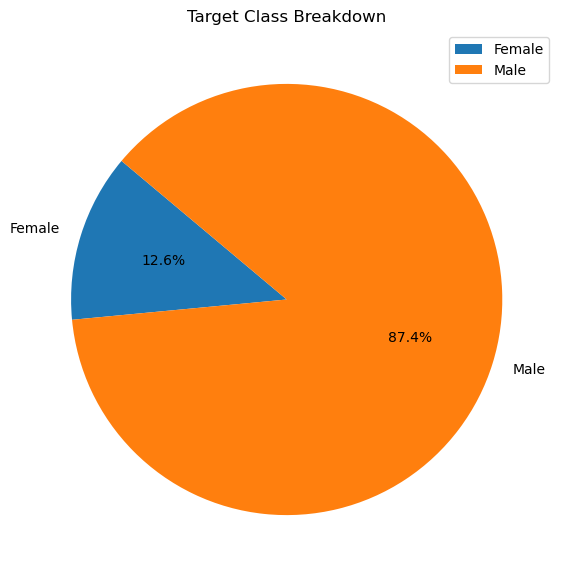

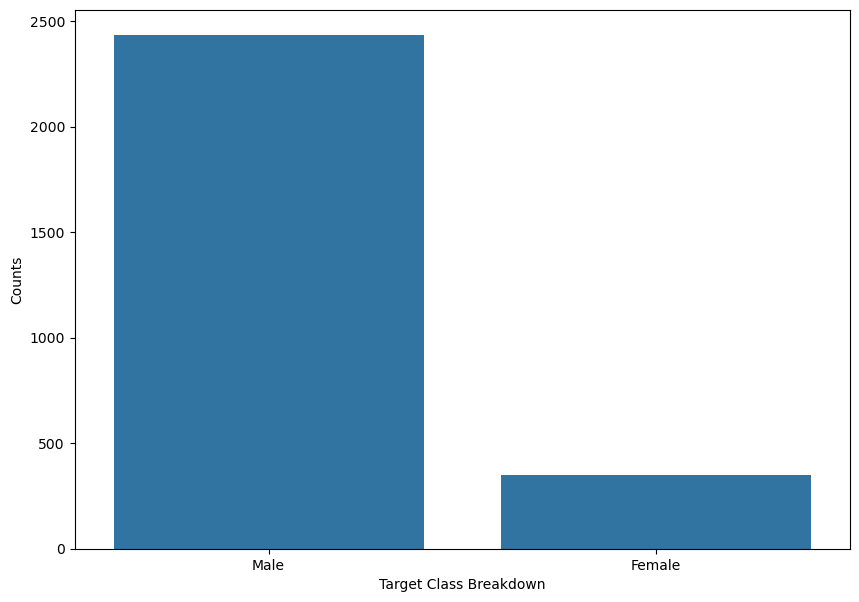

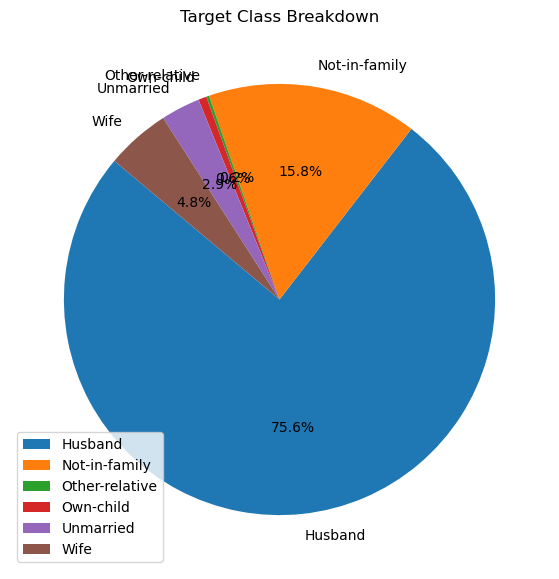

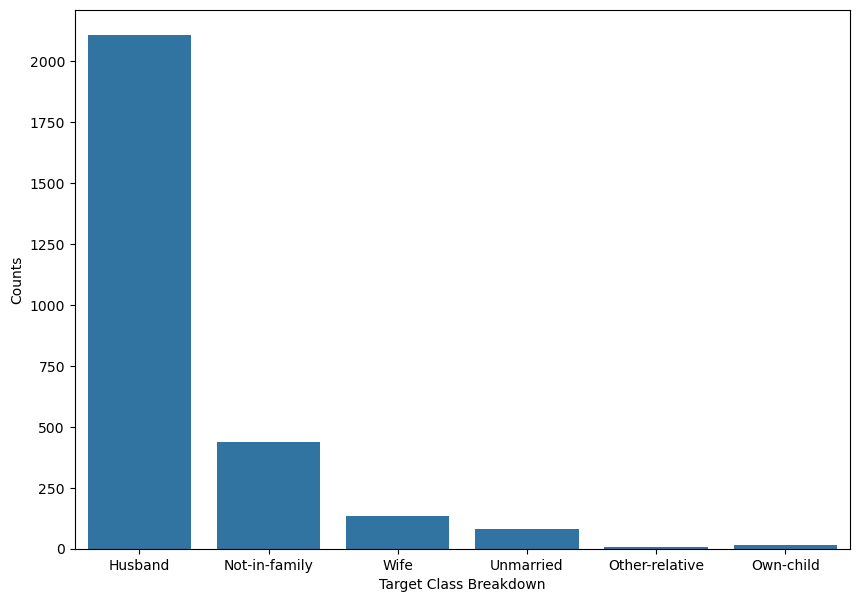

In [67]:
check_class_imbalance(long_hours_high_earners["marital-status"])
check_class_imbalance(long_hours_high_earners["gender"])
check_class_imbalance(long_hours_high_earners["relationship"])

# Create Preprocessor

In [60]:
df["education"].value_counts()

HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: education, dtype: int64